Imports & config

In [5]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import joblib

In [6]:
sns.set(style="whitegrid")
RESULTS_DIR = Path("../results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR = Path("../models");   MODELS_DIR.mkdir(parents=True, exist_ok=True)

Load data

A: full cleaned data (heart_disease_clean.csv)
B: feature-selected data (heart_selected.csv)

In [7]:
datasets = {    "clean":    "../data/heart_disease_clean.csv",   #  A
    "selected": "../data/heart_selected.csv",        #  B
    }
print(datasets)

{'clean': '../data/heart_disease_clean.csv', 'selected': '../data/heart_selected.csv'}


Model zoo

In [8]:
models = {
    "logreg": LogisticRegression(max_iter=2000, random_state=42),
    "dtree":  DecisionTreeClassifier(random_state=42),
    "rf":     RandomForestClassifier(n_estimators=300, random_state=42),
    "svm":    SVC(kernel="rbf", probability=True, random_state=42),
}

Helpers

In [9]:
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

def make_preprocessor(X):
    # coded categoricals that may exist in either dataset
    possible_cats = ["sex","cp","fbs","restecg","exang","slope","thal","ca"]
    cat_cols = [c for c in possible_cats if c in X.columns]
    num_cols = [c for c in X.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), num_cols),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", make_ohe())
            ]), cat_cols),
        ],
        remainder="drop"
    )
    return pre

def evaluate_model(name, estimator, pre, X_train, y_train, X_test, y_test, show_confmat=True):
    pipe = Pipeline([("pre", pre), ("clf", estimator)])
    pipe.fit(X_train, y_train)

    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    metrics = {
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred),
        "auc":       roc_auc_score(y_test, y_proba),
        "model":     pipe
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_auc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    metrics["cv_auc_mean"] = cv_auc.mean()
    metrics["cv_auc_std"]  = cv_auc.std()

    if show_confmat:
        cm = confusion_matrix(y_test, y_pred)
        fig = plt.figure(figsize=(3.5,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion – {name}"); plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout(); plt.show()

        print(f"Classification report – {name}")
        print(classification_report(y_test, y_pred, digits=3))

    return metrics

Train/evaluate BOTH datasets and collect results


================= DATASET: CLEAN =================

--- clean:logreg ---


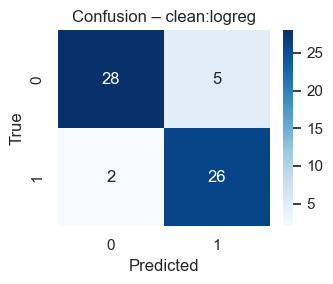

Classification report – clean:logreg
              precision    recall  f1-score   support

           0      0.933     0.848     0.889        33
           1      0.839     0.929     0.881        28

    accuracy                          0.885        61
   macro avg      0.886     0.889     0.885        61
weighted avg      0.890     0.885     0.885        61


--- clean:dtree ---


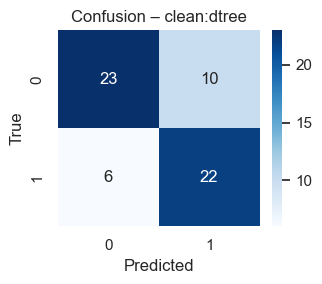

Classification report – clean:dtree
              precision    recall  f1-score   support

           0      0.793     0.697     0.742        33
           1      0.688     0.786     0.733        28

    accuracy                          0.738        61
   macro avg      0.740     0.741     0.738        61
weighted avg      0.745     0.738     0.738        61


--- clean:rf ---


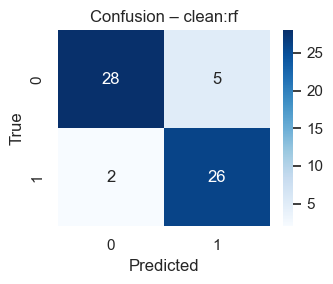

Classification report – clean:rf
              precision    recall  f1-score   support

           0      0.933     0.848     0.889        33
           1      0.839     0.929     0.881        28

    accuracy                          0.885        61
   macro avg      0.886     0.889     0.885        61
weighted avg      0.890     0.885     0.885        61


--- clean:svm ---


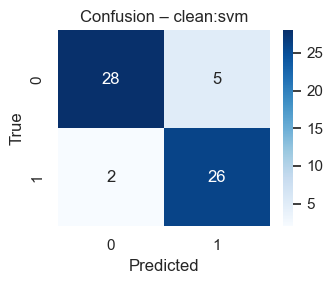

Classification report – clean:svm
              precision    recall  f1-score   support

           0      0.933     0.848     0.889        33
           1      0.839     0.929     0.881        28

    accuracy                          0.885        61
   macro avg      0.886     0.889     0.885        61
weighted avg      0.890     0.885     0.885        61



<Figure size 600x500 with 0 Axes>

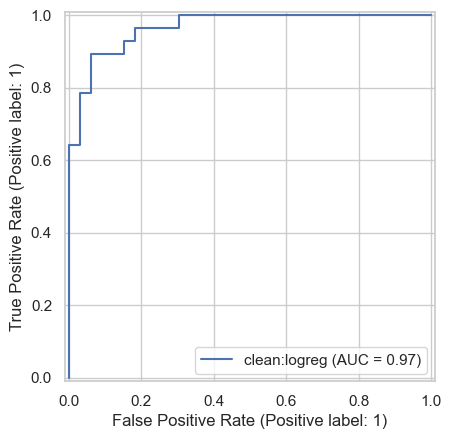

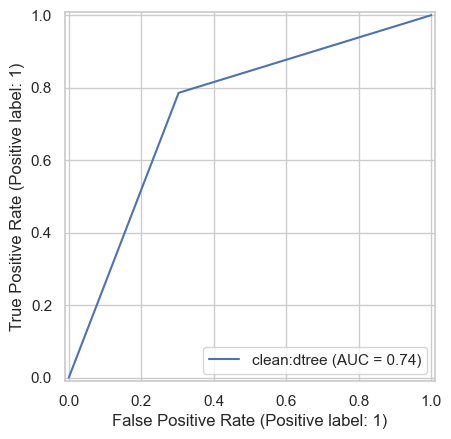

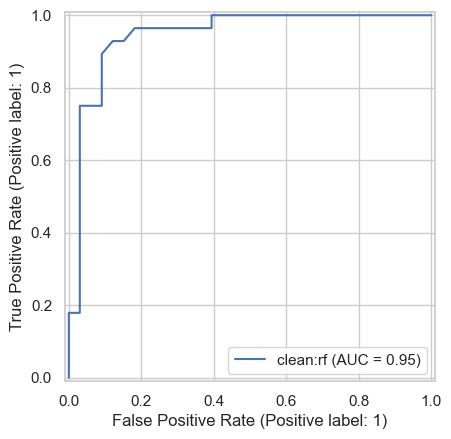

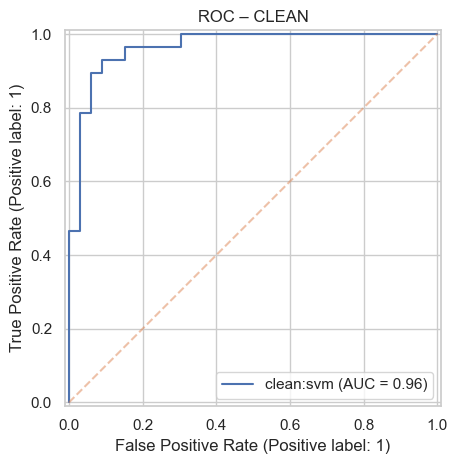

Best on clean: logreg (AUC=0.966) -> saved to ..\models\final_model_clean.pkl

================= DATASET: SELECTED =================

--- selected:logreg ---


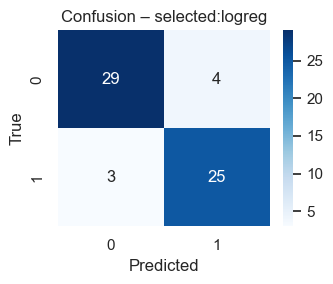

Classification report – selected:logreg
              precision    recall  f1-score   support

           0      0.906     0.879     0.892        33
           1      0.862     0.893     0.877        28

    accuracy                          0.885        61
   macro avg      0.884     0.886     0.885        61
weighted avg      0.886     0.885     0.885        61


--- selected:dtree ---


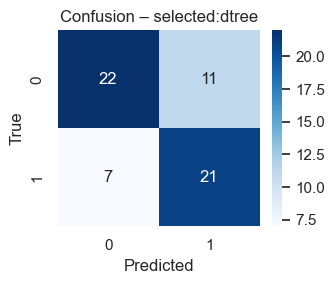

Classification report – selected:dtree
              precision    recall  f1-score   support

           0      0.759     0.667     0.710        33
           1      0.656     0.750     0.700        28

    accuracy                          0.705        61
   macro avg      0.707     0.708     0.705        61
weighted avg      0.712     0.705     0.705        61


--- selected:rf ---


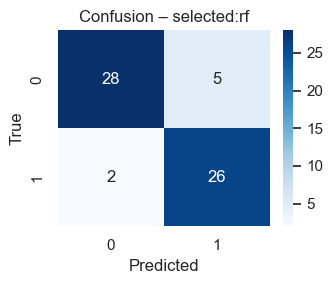

Classification report – selected:rf
              precision    recall  f1-score   support

           0      0.933     0.848     0.889        33
           1      0.839     0.929     0.881        28

    accuracy                          0.885        61
   macro avg      0.886     0.889     0.885        61
weighted avg      0.890     0.885     0.885        61


--- selected:svm ---


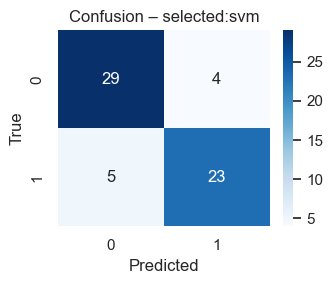

Classification report – selected:svm
              precision    recall  f1-score   support

           0      0.853     0.879     0.866        33
           1      0.852     0.821     0.836        28

    accuracy                          0.852        61
   macro avg      0.852     0.850     0.851        61
weighted avg      0.852     0.852     0.852        61



<Figure size 600x500 with 0 Axes>

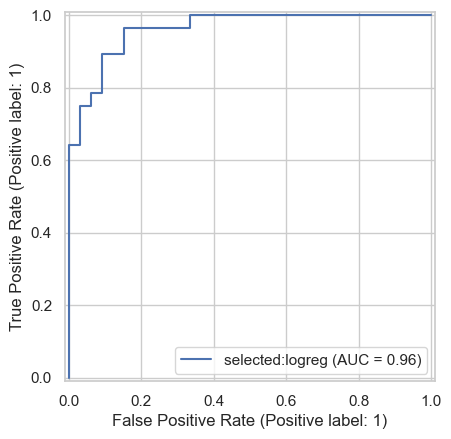

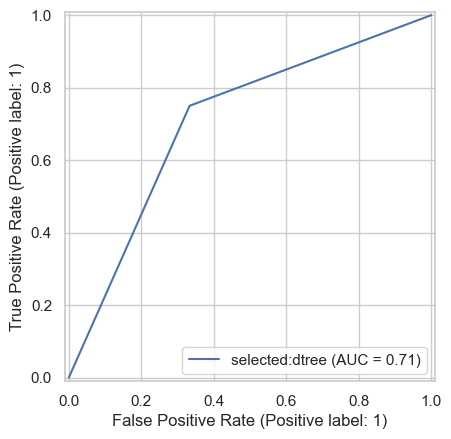

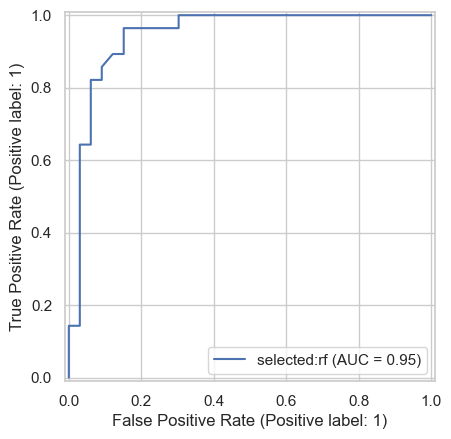

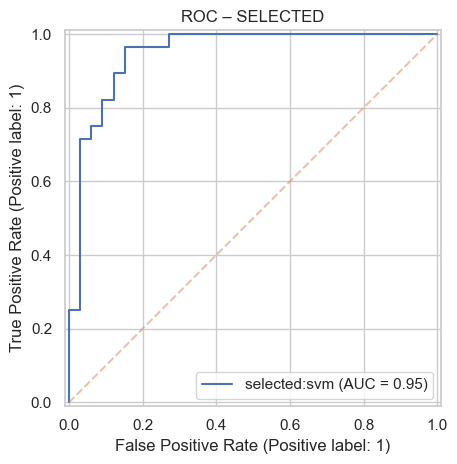

Best on selected: logreg (AUC=0.962) -> saved to ..\models\final_model_selected.pkl


In [10]:
all_rows = []
best_artifacts = {}


base_df = pd.read_csv(datasets["clean"])
idx_train, idx_test = train_test_split(
    base_df.index, test_size=0.2, stratify=base_df["target"], random_state=42)

for tag, path in datasets.items():
    print(f"\n================= DATASET: {tag.upper()} =================")
    df = pd.read_csv(path)
    y = df["target"]
    X = df.drop(columns=["target"])

    # same split indices
    X_train, X_test = X.loc[idx_train], X.loc[idx_test]
    y_train, y_test = y.loc[idx_train], y.loc[idx_test]

    pre = make_preprocessor(X)

    # Train each model
    metrics = {}
    for name, clf in models.items():
        print(f"\n--- {tag}:{name} ---")
        m = evaluate_model(f"{tag}:{name}", clf, pre, X_train, y_train, X_test, y_test)
        metrics[name] = m
        # record row
        row = {k:v for k,v in m.items() if k != "model"}
        row["model_name"] = name
        row["dataset"] = tag
        all_rows.append(row)

    # Plot ROC curves for this dataset
    plt.figure(figsize=(6,5))
    for name, m in metrics.items():
        RocCurveDisplay.from_estimator(m["model"], X_test, y_test, name=f"{tag}:{name}")
    plt.plot([0,1],[0,1],'--',alpha=0.5)
    plt.title(f"ROC – {tag.upper()}")
    plt.tight_layout(); plt.show()

    # Pick the best by AUROC for this dataset and save it
    best_name = max(metrics, key=lambda k: metrics[k]["auc"])
    best_model = metrics[best_name]["model"]
    model_path = MODELS_DIR / f"final_model_{tag}.pkl"
    joblib.dump(best_model, model_path)
    best_artifacts[tag] = (best_name, model_path, metrics[best_name]["auc"])
    print(f"Best on {tag}: {best_name} (AUC={metrics[best_name]['auc']:.3f}) -> saved to {model_path}")


Comparison table across BOTH datasets
dataset A: full cleaned data (heart_disease_clean.csv)
dataset B: feature-selected data (heart_selected.csv)

In [11]:
comparison = pd.DataFrame(all_rows)
ordered_cols = ["dataset","model_name","accuracy","precision","recall","f1","auc","cv_auc_mean","cv_auc_std"]
comparison = comparison[ordered_cols].sort_values(["dataset","auc"], ascending=[True, False])
display(comparison)

comparison.to_csv(RESULTS_DIR / "evaluation_metrics_comparison.csv", index=False)

for tag in datasets.keys():
    slice_df = comparison[comparison["dataset"] == tag]
    slice_df.to_csv(RESULTS_DIR / f"evaluation_metrics_{tag}.csv", index=False)

# TXT summary
with open(RESULTS_DIR / "evaluation_metrics_comparison.txt","w") as f:
    for tag, (best_name, model_path, auc) in best_artifacts.items():
        f.write(f"{tag}: best={best_name} AUC={auc:.3f} path={model_path}\n")

print("Saved:")
print(" - ../results/evaluation_metrics_comparison.csv (+ per-dataset CSVs)")
print(" - ../results/evaluation_metrics_comparison.txt")
for tag, (best_name, model_path, auc) in best_artifacts.items():
    print(f" - Best {tag} model: {best_name} -> {model_path}")


,dataset,model_name,accuracy,precision,recall,f1,auc,cv_auc_mean,cv_auc_std
0,clean,logreg,0.885246,0.838710,0.928571,0.881356,0.966450,0.902493,0.014440
3,clean,svm,0.885246,0.838710,0.928571,0.881356,0.964286,0.888373,0.024024
2,clean,rf,0.885246,0.838710,0.928571,0.881356,0.945887,0.890299,0.034538
1,clean,dtree,0.737705,0.687500,0.785714,0.733333,0.741342,0.685542,0.051233
4,selected,logreg,0.885246,0.862069,0.892857,0.877193,0.962121,0.908474,0.003570
7,selected,svm,0.852459,0.851852,0.821429,0.836364,0.948052,0.893995,0.022280
6,selected,rf,0.885246,0.838710,0.928571,0.881356,0.945346,0.885751,0.027313
5,selected,dtree,0.704918,0.656250,0.750000,0.700000,0.708333,0.710989,0.051826


Saved:
 - ../results/evaluation_metrics_comparison.csv (+ per-dataset CSVs)
 - ../results/evaluation_metrics_comparison.txt
 - Best clean model: logreg -> ..\models\final_model_clean.pkl
 - Best selected model: logreg -> ..\models\final_model_selected.pkl
